# Part 2 - Regression with Image

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda'
learning_rate = 0.01
momentum = 0.5
n_epochs = 50

# Prepare MNIST image dataset

### Define Image transform

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                (0.1307,), (0.3081,))])

### Download torchvision data

In [4]:
traindata = torchvision.datasets.MNIST('./data', train=True, download=True,
                                       transform=transform)
testdata = torchvision.datasets.MNIST('./data', train=False, download=True,
                                      transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


### Create dataloader

In [5]:
batch_size_train = 128
batch_size_test = 32

train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size_test, 
                                           shuffle=True)

# Define Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [7]:
network = Net().to(device)
# optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(network.parameters())

# Train Model

In [8]:
train_losses, train_counter, test_losses = [], [], []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [9]:
def evaluate():
    network.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            result = output.squeeze(dim=1).int().cpu() == target.cpu() # Compare predictions and target
            test_loss += F.mse_loss(output.squeeze(dim=1), target.float(), size_average=False).item()
            correct += np.count_nonzero(result) # Count occurences of true
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
for epoch in range(1, n_epochs + 1):
    log_interval = 100
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.mse_loss(output.squeeze(dim=1), target.float())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')
    evaluate()

Train Epoch: 1 [0/60000 (0%)]	Loss: 28.823910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 5.989944
Train Epoch: 1 [25600/60000 (43%)]	Loss: 4.137180
Train Epoch: 1 [38400/60000 (64%)]	Loss: 4.804254
Train Epoch: 1 [51200/60000 (85%)]	Loss: 3.423614

Test set: Avg. loss: 1.8851, Accuracy: 3147/10000 (31%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 3.465488
Train Epoch: 2 [12800/60000 (21%)]	Loss: 3.847491
Train Epoch: 2 [25600/60000 (43%)]	Loss: 3.530257
Train Epoch: 2 [38400/60000 (64%)]	Loss: 3.411666
Train Epoch: 2 [51200/60000 (85%)]	Loss: 3.451501

Test set: Avg. loss: 1.3071, Accuracy: 3876/10000 (39%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 4.332509
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.050848
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.596013
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.466577
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.940311

Test set: Avg. loss: 1.2214, Accuracy: 3536/10000 (35%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.379365
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.60

# Test Model

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    predictions = network(example_data.to(device))

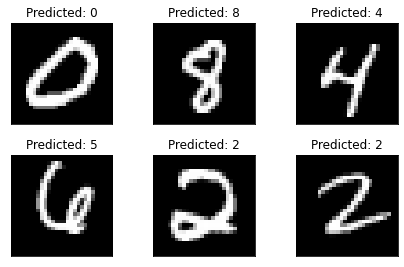

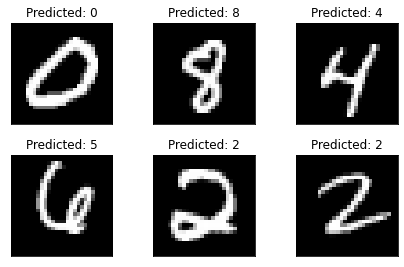

In [12]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Predicted: {}".format(predictions.squeeze(dim=1).int().cpu().detach().numpy()[i]))
    plt.xticks([])
    plt.yticks([])
fig

### View model weights

In [13]:
for name, param in network.state_dict().items():
    print("Layer: ", name)
    print(param)
    print()

Layer:  conv1.weight
tensor([[[[ 9.2725e-03,  3.0475e-03, -5.9572e-02, -2.4893e-02, -1.0225e-01],
          [ 9.8561e-02, -2.2867e-03, -6.8672e-03, -1.1502e-01, -4.4024e-02],
          [ 1.6222e-02, -5.9460e-03, -8.4729e-02,  8.4497e-02,  3.9024e-03],
          [ 1.0397e-01,  3.6386e-02, -7.8399e-02, -1.1625e-02, -3.9311e-02],
          [ 5.6034e-02,  1.5568e-01,  4.5380e-02,  4.4807e-02,  8.3788e-02]]],


        [[[ 1.7877e-02, -2.4424e-02,  1.0138e-01,  7.2517e-02, -2.3067e-02],
          [-4.0851e-03, -3.2523e-02, -6.0414e-02, -7.2713e-03,  1.2444e-01],
          [-1.0952e-01, -6.5611e-02,  1.6726e-03,  1.5761e-02,  1.3551e-01],
          [-1.0870e-01, -7.4104e-02,  3.7252e-02,  7.9684e-02,  1.3328e-02],
          [-2.4558e-01, -8.6457e-02, -8.4472e-02,  1.2214e-02,  1.2648e-01]]],


        [[[-1.3608e-02,  3.3743e-02,  1.0512e-01,  8.1298e-02,  2.8020e-01],
          [-8.1680e-02,  1.8062e-02, -5.6722e-02,  3.3975e-02, -8.1927e-02],
          [-8.5149e-02,  3.6634e-02, -7.5158e-0